In [1]:
!pip install psaw

In [4]:
from psaw import PushshiftAPI
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import datetime

import nltk; nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import FreqDist 
import re
import requests, json
import os

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sprihajoshi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
#api = PushshiftAPI()
#start=int(datetime.datetime(2021, 2, 10).timestamp())
#end=int(datetime.datetime(2021, 2, 28).timestamp())

#api_request_generator = api.search_submissions(subreddit='wallstreetbets', after=start, before=end)

In [17]:
#wsb_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

In [18]:
#wsb_submissions.to_csv("posts_retrieved_from_api.csv")

In [19]:
wsb_submissions = pd.read_csv("posts_retrieved_from_api.csv")

/Users/sprihajoshi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,68,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
wsb_submissions['date'] = pd.to_datetime(wsb_submissions['created_utc'], utc=True, unit='s')

In [21]:
# Tags in WSB
wsb_submissions["link_flair_text"].unique()

array(['Meme', 'Discussion', 'Loss', 'News', 'YOLO', 'Chart', 'Gain',
       'DD', nan, 'Earnings Thread', 'Shitpost', 'Weekend Discussion',
       'Daily Discussion', 'Mods', 'OC'], dtype=object)

In [22]:
DDdata = wsb_submissions[wsb_submissions["link_flair_text"] == "DD"][["id", "title"]]
YOLOdata = wsb_submissions[wsb_submissions["link_flair_text"] == "YOLO"][["id", "title"]]

In [23]:
tickers = pd.read_csv("tickers.csv")
# https://github.com/tomsant/wsbTrendingStonks

In [100]:
tickers.head()

,Symbol,Name
0,A,Agilent Technologies Inc. Common Stock
1,AA,Alcoa Corporation Common Stock
2,AACG,ATA Creativity Global American Depositary Shares
3,AACQ,Artius Acquisition Inc. Class A Common Stock
4,AACQU,Artius Acquisition Inc. Unit


In [24]:
tickers_dict = dict()

for _ in range(len(tickers)):
    tickers_dict[tickers.iloc[_, 0]] = tickers.iloc[_, 1]

After a thorough examination of the posts, they were cleaned and processed in the following manner: <br>
(1) Punctuation marks were removes -> this also excluded any of the emojis made by the users using punctuation marks <br>
(2) The text was tokenised <br>
(3) stop words were remved as they dont add any meaning(sentiment)<br>
(4) words like DD, YOLO were removed as they could be mistaken for stock tickers in the pipeline later on whereas the users mostly added to update each other on their standings(YOLO) on a particular stock or make a Due Diligence.
eg. " AMC DD" <br>

In [25]:
def remove_stopword(listt):
    return [word for word in listt if word.lower() not in stopwords.words('english')]

def clean(series):
    #Look for tickers and keep them caps, make the rest small
    #remove stopwords
    #remove punctuation marks
    #remove DD, Yolo, YOLO 
    s=[]
    
    for index, title in series.iteritems():
        
        #Remove punctuations
        title = re.sub(r'[^\w\s]', '', title) 
        
        #Tokenize
        title_into_words = title.split()
        
        #Remove stopwords
        title_wo_sw = remove_stopword(title_into_words)
        
        if "DD" in title_wo_sw:
            title_wo_sw.remove("DD")
        if "YOLO" in title_wo_sw:
            title_wo_sw.remove("YOLO")
        if "Yolo" in title_wo_sw:
            title_wo_sw.remove("Yolo")
        
        new_list = []
        
        for word in title_wo_sw:
            if word not in tickers_dict.keys():
                new_list.append(word.lower()) 
            else:
                new_list.append(word.upper())
                    
        #print(title_wo_sw)
        s.append(new_list)
        
    return s

In [26]:
DDdata["Tokenized"] = clean(DDdata["title"])
YOLOdata["Tokenized"] = clean(YOLOdata["title"])

In [27]:
DDdata[["title","Tokenized"]].head()

,title,Tokenized
23,Using Covered Calls to Buy Volatile Stocks lik...,"[using, covered, calls, buy, volatile, stocks,..."
93,Meme stock price target,"[meme, stock, price, target]"
116,Cryptography DD,[cryptography]
150,This is...,[]
165,I see a lot of memes about AMC and other stock...,"[see, lot, memes, AMC, stocks, GME]"


In [99]:
YOLOdata[["title","Tokenized"]].tail()

,title,Tokenized
107625,Real reasons I think bitTorrent is going to bl...,"[real, reasons, think, bittorrent, going, blow]"
107629,"Holding 🍿, 1️⃣4️⃣0️⃣0️⃣0️⃣ $GME for #MOASS 🚀 o...","[holding, 14000, GME, moass, retirement]"
107630,WHOS READY TO THROW 💎👊 FOR DFV???,"[whos, ready, throw, dfv]"
107634,Loss porn: started with 3 shares @ $234 and ha...,"[loss, porn, started, 3, shares, 234, done, ul..."
107637,🙌🏼 💎,[]


As we can see from the results above: emojis, punctuation marks etc were removed and only the rest are split into tokens where stock tickers are still kept in upper case whereas the rest was made to lowercase to be able to differentiate them easily i.e. to not confuse them with comments that are all in uppercase eg. A is a ticker too but the user probably wrote the comment in uppercase and did not mean to mention the stock A. Same with tickers named GO, NEXT etc.  

In [29]:
def getCount(data):
    ticker_count = FreqDist()
    for listt in data.Tokenized:
        for word in listt:
            if word in tickers_dict.keys():
                ticker_count[word] += 1
    return ticker_count

In [30]:
def todf(ticker_count):
    df = pd.DataFrame.from_dict(ticker_count, orient='index')
    df.columns = ['Frequency']
    df.index.name = 'Ticker'
    df.sort_values(by="Frequency", ascending=False, inplace=True)
    df.reset_index(inplace=True)
    return df

Now that we have our data cleaned and our tickers ready, we can count the number of times these tickers were mentioned in each of the two categories (DD and YOLO) to find out the most talked about tickers. This can then be presented using a Frequency plot. 

In [31]:
DDdata_count = getCount(DDdata)
YOLOdata_count = getCount(YOLOdata)

In [32]:
DDdf = todf(DDdata_count)
YOLOdf = todf(YOLOdata_count)

In [33]:
DDdf.head(10) 

,Ticker,Frequency
0,GME,549
1,AMC,234
2,SNDL,168
3,SOS,99
4,PLTR,94
5,TLRY,81
6,RKT,58
7,EV,55
8,APHA,50
9,BB,46


In [34]:
[tickers_dict.get(ticker) for ticker in DDdf.Ticker.head(10) if ticker in tickers_dict.keys()]

['GameStop Corporation Common Stock',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Sundial Growers Inc. Common Shares',
 'SOS Limited American Depositary Shares',
 'Palantir Technologies Inc. Class A Common Stock',
 'Tilray Inc. Class 2 Common Stock',
 'Rocket Companies Inc. Class A Common Stock',
 'Eaton Vance Corporation Common Stock',
 'Aphria Inc. Common Shares',
 'BlackBerry Limited Common Stock']

In [35]:
YOLOdf.head(10)

,Ticker,Frequency
0,GME,1564
1,AMC,1196
2,SNDL,544
3,PLTR,269
4,TLRY,120
5,CCIV,112
6,NOK,98
7,GO,97
8,SOS,90
9,CTRM,83


In [36]:
[tickers_dict.get(ticker) for ticker in YOLOdf.Ticker.head(10) if ticker in tickers_dict.keys()]

['GameStop Corporation Common Stock',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Sundial Growers Inc. Common Shares',
 'Palantir Technologies Inc. Class A Common Stock',
 'Tilray Inc. Class 2 Common Stock',
 'Churchill Capital Corp IV Class A Common Stock',
 'Nokia Corporation Sponsored American Depositary Shares',
 'Grocery Outlet Holding Corp. Common Stock',
 'SOS Limited American Depositary Shares',
 'Castor Maritime Inc. Common Shares']

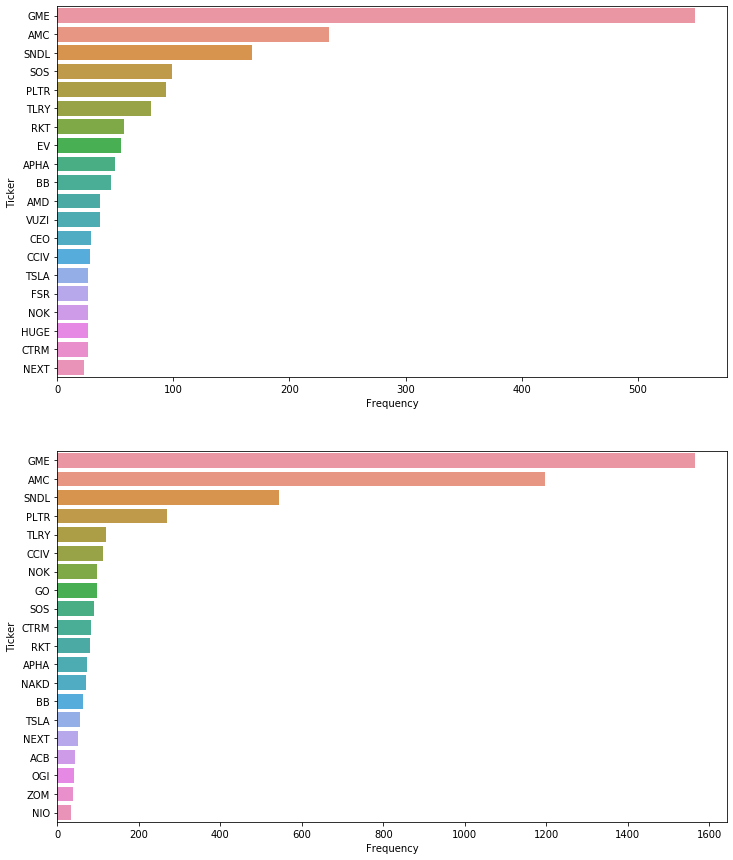

In [37]:
fig, ax = plt.subplots(2, figsize=(12,15))
sns.barplot(y='Ticker', x='Frequency', data=DDdf.head(20), ax=ax[0])
sns.barplot(y='Ticker', x='Frequency', data=YOLOdf.head(20), ax=ax[1])

Here we see GME is still the most talked about ticker in both DD and YOLO - as the GME was decreasing in the chosen time period (10th Feb-28th Feb 2021). However besides GME, we see AMC, SNDL, SOS, PLTR and TLRY as the top tickers in DD posts and AMC, SNDL, PLTR, TLRY and CCIV as the top tickers in YOLO posts.

Now, lets look at the comments of the posts above and extract the sentiment towards each ticker to further understand if these ticker popularity is positive or negative! 

## Sentiment towards top 10 tickers

In [38]:
def fetch_comments(submission_id):
    fields = ["body","id","link_id","parent_id"]
    allcomments = requests.get("https://api.pushshift.io/reddit/comment/search/?submission_id="+submission_id)
    if not allcomments.status_code==200:
        print('Unable to perform request with status code: ' + str(allcomments.status_code))
        return pd.DataFrame(columns=fields)
    else:
        comment_ids = getComment_id(allcomments)
        filtered_comments = requests.get("https://api.pushshift.io/reddit/comment/search?ids="+comment_ids+"&fields=body,id,link_id,parent_id"+"&size="+str(min(len(comment_ids),50)))
        #print("https://api.pushshift.io/reddit/comment/search?ids="+comment_ids+"&fields=body,id,link_id,parent_id")
        if not filtered_comments.status_code==200:
            print('Unable to perform request with status code: ' + str(filtered_comments.status_code))
            return pd.DataFrame(columns=fields)
        else: 
            return pd.DataFrame(json.loads(filtered_comments.text)["data"])

def getComment_id(result):
    s=""
    for dicti in json.loads(result.text)["data"]:
        s+=dicti.get("id")+","
    return s[:-1]

In [39]:
def comments_toSeries(data):
    return [fetch_comments(submission_id=data.iloc[i]['id']) for i in range(data.shape[0])]

In [49]:
commentsDD = pd.read_csv("DDsubmissions.csv")

In [50]:
commentsYOLO = pd.read_csv("YOLOsubmissions.csv")

In [51]:
commentsDD.drop(commentsDD.columns[0], axis=1, inplace=True)
commentsDD['date'] = pd.to_datetime(commentsDD['utc'], utc=True, unit='s')

commentsYOLO.drop(commentsYOLO.columns[0], axis=1, inplace=True)
commentsYOLO['date'] = pd.to_datetime(commentsYOLO['utc'], utc=True, unit='s')

In [52]:
# We restrict the comments to the same timeline as before i.e. 10th till 28th Feb 2021. 

commentsDD = commentsDD[commentsDD["date"]>=min(commentsDD["date"])]
commentsDD = commentsDD[commentsDD["date"]<=min(commentsDD["date"]) + datetime.timedelta(days=18)]

commentsYOLO = commentsYOLO[commentsYOLO["date"]>=min(commentsYOLO["date"])]
commentsYOLO = commentsYOLO[commentsYOLO["date"]<=min(commentsYOLO["date"]) + datetime.timedelta(days=18)]

In [53]:
commentsDD.shape, commentsYOLO.shape

((27840, 8), (27519, 8))

In [54]:
commentsDD["Tokenized"] = clean(commentsDD["body"])
commentsDD["Tokenized_joined"] = commentsDD["Tokenized"].apply(lambda x: ' '.join(x))

In [55]:
commentsYOLO["Tokenized"] = clean(commentsYOLO["body"])
commentsYOLO["Tokenized_joined"] = commentsYOLO["Tokenized"].apply(lambda x: ' '.join(x))

In [56]:
commentsDD.to_csv("cleanedDDcomments.csv")
commentsYOLO.to_csv("cleanedYOLOcomments.csv")

In [57]:
commentsDD.head(2)

,sub_id,body,id,link_id,parent_id,subreddit,utc,date,Tokenized,Tokenized_joined
0,ltzb4d,Another downside is that the stock plummets an...,gp3h2a6,t3_ltzb4d,t3_ltzb4d,wallstreetbets,1.614468e+09,2021-02-27 23:16:23+00:00,"[another, downside, stock, plummets, youre, le...",another downside stock plummets youre left hol...
1,ltzb4d,Exactly what I've wanted to do but don't have ...,gp3dj89,t3_ltzb4d,t3_ltzb4d,wallstreetbets,1.614467e+09,2021-02-27 22:55:21+00:00,"[exactly, ive, wanted, dont, bankroll, buy, 10...",exactly ive wanted dont bankroll buy 100 share...


In [58]:
commentsYOLO.head(2)

,sub_id,body,id,link_id,parent_id,subreddit,utc,date,Tokenized,Tokenized_joined
0,ltzb06,Wtf is this shit normie. Why slow down a video...,gp3dfmy,t3_ltzb06,t3_ltzb06,wallstreetbets,1.614466e+09,2021-02-27 22:54:46+00:00,"[wtf, shit, normie, slow, video, know, people,...",wtf shit normie slow video know people autism ...
1,ltzb06,🥶,gp3gdal,t3_ltzb06,t3_ltzb06,wallstreetbets,1.614468e+09,2021-02-27 23:11:46+00:00,[],


In [59]:
def getSentiments(series):
    sentiment_label=[]
    for comment in series:
        model = SentimentIntensityAnalyzer()
        sentiment = model.polarity_scores(comment)
        positive, neutral, negative = sentiment['pos'], sentiment['neu'], sentiment['neg']
        
        if comment=="":
            sentiment_label.append("neutral "+str(neutral))
        else:
            if max(positive,neutral,negative) == positive:
                sentiment_label.append("positive "+str(positive))
            elif max(positive,neutral,negative) == negative:
                sentiment_label.append("negative "+str(negative))
            else: 
                sentiment_label.append("neutral "+str(neutral))
        #print(comment," : ",sentiment_label)
        #print(len(sentiment_label),"/",len(series))
        
    return sentiment_label

In [60]:
def getTickerofthecomment(series):
    tickerincomment = []
    for comment in series:
        #print(comment)
        ticker_count = FreqDist()
        for word in comment:
            if word in tickers_dict.keys():
                ticker_count[word] += 1
        ticker_count = dict(ticker_count)
        if len(ticker_count)==0:
            tickerincomment.append(None)
        elif len(ticker_count)==1:
            tickerincomment.append(list(ticker_count.keys())[0])
        else:
            tickerincomment.append(max(ticker_count, key=ticker_count.get))
        #print(len(tickerincomment),"/",len(series))
    return tickerincomment

In [61]:
commentsDD["comment_sentiment"] = getSentiments(commentsDD["Tokenized_joined"])

In [62]:
commentsDD["comment_ticker"] = getTickerofthecomment(commentsDD["Tokenized"])

In [63]:
commentsYOLO["comment_sentiment"] = getSentiments(commentsYOLO["Tokenized_joined"])

In [64]:
commentsYOLO["comment_ticker"] = getTickerofthecomment(commentsYOLO["Tokenized"])

In [65]:
commentsYOLO.to_csv("YOLOcomments_Sentiments_beforescore.csv")
commentsDD.to_csv("DDcomments_Sentiments_beforescore.csv")

In [66]:
#commentsYOLO = pd.read_csv("YOLOcomments_Sentiments_beforescore.csv")
#commentsDD = pd.read_csv("DDcomments_Sentiments_beforescore.csv")

In [67]:
#commentsYOLO.drop(commentsYOLO.columns[[0,13]], axis=1, inplace=True)
#commentsDD.drop(commentsDD.columns[[0,13]], axis=1, inplace=True)

In [68]:
commentsYOLO[['comment_sentiment','sentiment_score']] = commentsYOLO['comment_sentiment'].str.split(' ', expand=True)

In [69]:
commentsDD[['comment_sentiment','sentiment_score']] = commentsDD['comment_sentiment'].str.split(' ', expand=True)

In [70]:
commentsDD[["body","Tokenized","comment_sentiment", "comment_ticker", "sentiment_score"]].head(2)

,body,Tokenized,comment_sentiment,comment_ticker,sentiment_score
0,Another downside is that the stock plummets an...,"[another, downside, stock, plummets, youre, le...",neutral,GME,0.807
1,Exactly what I've wanted to do but don't have ...,"[exactly, ive, wanted, dont, bankroll, buy, 10...",neutral,None,0.635


In [71]:
commentsYOLO[["body","Tokenized","comment_sentiment", "comment_ticker", "sentiment_score"]].tail(2)

,body,Tokenized,comment_sentiment,comment_ticker,sentiment_score
27718,"The YOLO flair exists for the highest stakes, ...","[flair, exists, highest, stakes, highest, risk...",neutral,None,0.606
27719,"The YOLO flair exists for the highest stakes, ...","[flair, exists, highest, stakes, highest, risk...",neutral,None,0.606


In [72]:
commentsYOLO.to_csv("YOLOcomments_Sentiments.csv")
commentsDD.to_csv("DDcomments_Sentiments.csv")

In [ ]:
#commentsYOLO = pd.read_csv("YOLOcomments_Sentiments.csv")
#commentsDD = pd.read_csv("DDcomments_Sentiments.csv")

In [77]:
commentsYOLO["sentiment_score"] = commentsYOLO["sentiment_score"].astype(float)
commentsDD["sentiment_score"] = commentsDD["sentiment_score"].astype(float)

In [78]:
def sentAnalysis(data, ddf):
    sentiments_perticker = dict()
    for popticker in ddf.head(10)["Ticker"]:
        pos = 0
        neg = 0
        neu = 0
        df = data[data["comment_ticker"]==popticker]
        total = len(df)
        for senti,score in zip(df["comment_sentiment"],df["sentiment_score"]):
            if senti=="positive":
                pos+=score
            if senti=="negative":
                neg+=score
            if senti=="neutral":
                neu+=score
        sentiments_perticker[popticker] = [(pos/total),(neg/total),(neu/total)]
    return sentiments_perticker

In [79]:
DDsentiments_perticker = pd.DataFrame(sentAnalysis(commentsDD, DDdf), index=["Positive", "Negative", "Neutral"]).transpose()

In [80]:
YOLOsentiments_perticker = pd.DataFrame(sentAnalysis(commentsYOLO, YOLOdf), index=["Positive", "Negative", "Neutral"]).transpose()

In [89]:
YOLOsentiments_perticker.sort_values(by=["Positive"], inplace=True, ascending=False)
DDsentiments_perticker.sort_values(by=["Positive"], inplace=True, ascending=False)

In [94]:
YOLOsentiments_perticker = YOLOsentiments_perticker[YOLOsentiments_perticker['Positive'] != 0]
DDsentiments_perticker = DDsentiments_perticker[DDsentiments_perticker['Positive'] != 0]

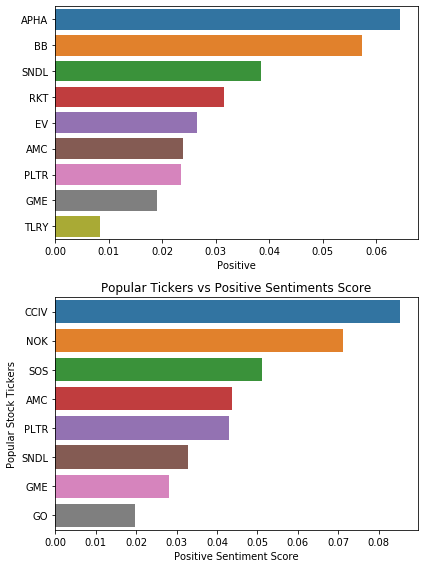

In [95]:
fig, ax = plt.subplots(2, figsize=(6,8))
sns.barplot(y=DDsentiments_perticker.index, x='Positive', data=DDsentiments_perticker, ax=ax[0])
sns.barplot(y=YOLOsentiments_perticker.index, x='Positive', data=YOLOsentiments_perticker, ax=ax[1])

plt.title('Popular Tickers vs Positive Sentiments Score')
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Popular Stock Tickers')
plt.tight_layout()
plt.show()

In [98]:
[tickers_dict.get(ticker) for ticker in DDsentiments_perticker.index if ticker in tickers_dict.keys()]

['Aphria Inc. Common Shares',
 'BlackBerry Limited Common Stock',
 'Sundial Growers Inc. Common Shares',
 'Rocket Companies Inc. Class A Common Stock',
 'Eaton Vance Corporation Common Stock',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Palantir Technologies Inc. Class A Common Stock',
 'GameStop Corporation Common Stock',
 'Tilray Inc. Class 2 Common Stock']

In [97]:
[tickers_dict.get(ticker) for ticker in YOLOsentiments_perticker.index if ticker in tickers_dict.keys()]

['Churchill Capital Corp IV Class A Common Stock',
 'Nokia Corporation Sponsored American Depositary Shares',
 'SOS Limited American Depositary Shares',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Palantir Technologies Inc. Class A Common Stock',
 'Sundial Growers Inc. Common Shares',
 'GameStop Corporation Common Stock',
 'Grocery Outlet Holding Corp. Common Stock']

We found that comments were mostly neutral towards all tickers. If we look at the positive sentiment scores only, then we see that in DD posts, APHA and BB received the highest (which was not very high as it was neutral by majority) positive sentiments by the commenters. However, SNDL and AMC follow right after with PLTR and TLRY also making it to the top 10 atleast which would then be consistent with the graph before. 
For YOLO posts,  CCIV and NOK received the highest positive sentiments by the commenters and similar to DD posts, AMC, SNDL and PLTR follow right after. 

In both cases though, GME can be seen in the bottom tier and this can be explained by the dropping prices of GME in the timeframe under consideration for this task. But that was intentional as we wanted to find out the tickers that, as redditers will say, "are going to the moon next" and from analysis AMC, SNDL then PLTR and TLRY seem to be the ones. 